In [9]:
# Core Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Handle imbalanced data
from imblearn.over_sampling import SMOTE

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


In [11]:
df = pd.read_csv("blood.csv")

# Basic info
print(df.head())
print(df.info())
print(df['Class'].value_counts())

# Remove duplicates
df.drop_duplicates(inplace=True)


   Recency  Frequency  Monetary  Time  Class
0        2         50     12500    99      1
1        0         13      3250    28      1
2        1         17      4000    36      1
3        2         20      5000    45      1
4        1         24      6000    77      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None
Class
0    570
1    178
Name: count, dtype: int64


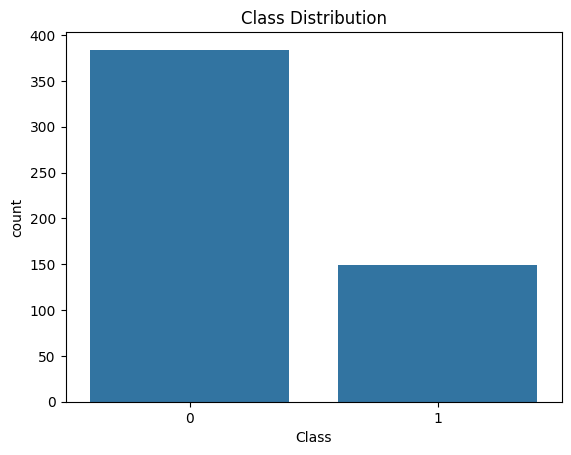

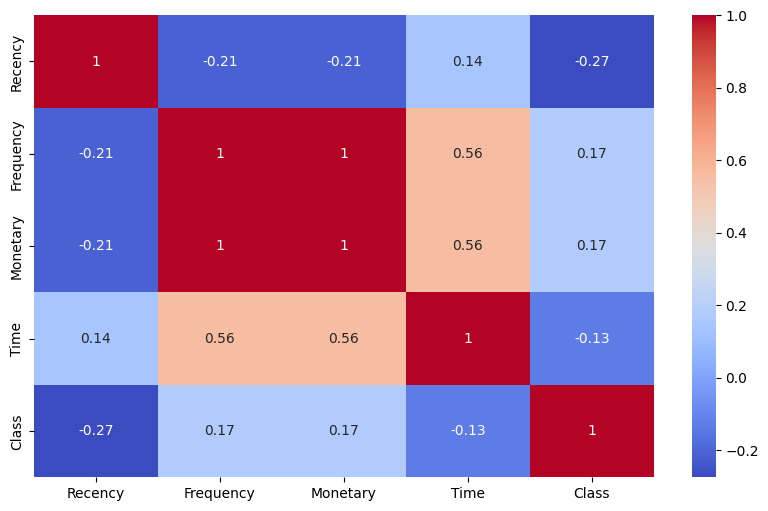

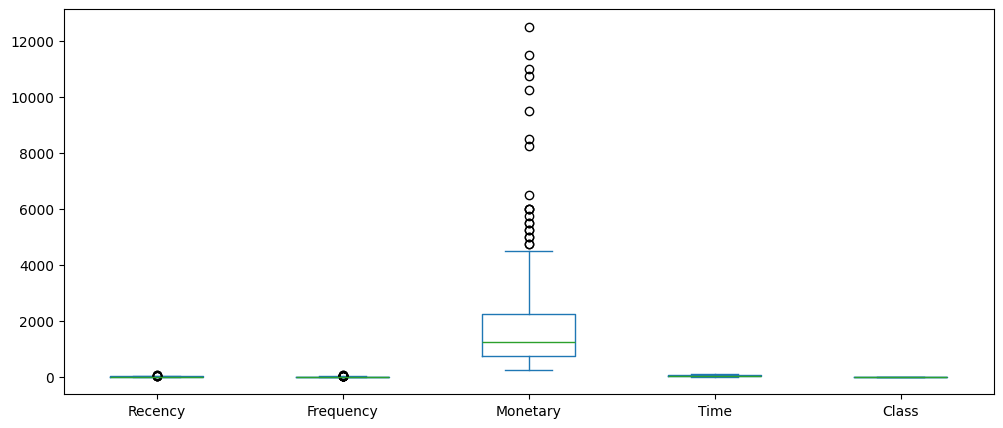

In [13]:
# Class distribution
sns.countplot(x=df['Class'])
plt.title("Class Distribution")
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Boxplot to check outliers
df.plot(kind='box', figsize=(12,5))
plt.show()


In [17]:
def cap_outliers(series):
    Q1, Q3 = series.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return np.where(series < lower, lower, np.where(series > upper, upper, series))

for col in ['Recency','Frequency','Monetary','Time']:
    df[col] = cap_outliers(df[col])


In [19]:
# Select features
X = df[['Recency','Frequency','Monetary','Time']]
y = df['Class']

# Replace inf with NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Drop rows with NaN
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]  # align y with X

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to NumPy arrays
X_np = X_scaled
y_np = y.values


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y_np, test_size=0.2, random_state=42, stratify=y_np
)


In [23]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))


Before SMOTE: [307 119]
After SMOTE: [307 307]


In [25]:
# Add interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_res)
X_test_poly = poly.transform(X_test)


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


In [29]:
results = {}

for name, model in models.items():
    # Train on SMOTE balanced data
    model.fit(X_train_res, y_train_res)
    
    # Predict on original test set
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    print(f"{name} Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # ROC-AUC
    if y_prob is not None:
        roc_auc = roc_auc_score(y_test, y_prob)
        print(f"{name} ROC-AUC: {roc_auc:.4f}")
        results[name] = roc_auc
    else:
        # For SVM without predict_proba, we skip ROC-AUC
        results[name] = accuracy_score(y_test, y_pred)



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.66      0.76        77
           1       0.48      0.80      0.60        30

    accuracy                           0.70       107
   macro avg       0.69      0.73      0.68       107
weighted avg       0.78      0.70      0.72       107

Logistic Regression Confusion Matrix:
 [[51 26]
 [ 6 24]]
Logistic Regression ROC-AUC: 0.7913

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77        77
           1       0.44      0.53      0.48        30

    accuracy                           0.68       107
   macro avg       0.62      0.64      0.63       107
weighted avg       0.70      0.68      0.69       107

Random Forest Confusion Matrix:
 [[57 20]
 [14 16]]
Random Forest ROC-AUC: 0.6742

SVM Classification Report:
              precision    recall  f1-score   support

     

In [30]:
best_model_name = max(results, key=results.get)
print(f"\nBest Model based on ROC-AUC/Accuracy: {best_model_name}")



Best Model based on ROC-AUC/Accuracy: Logistic Regression


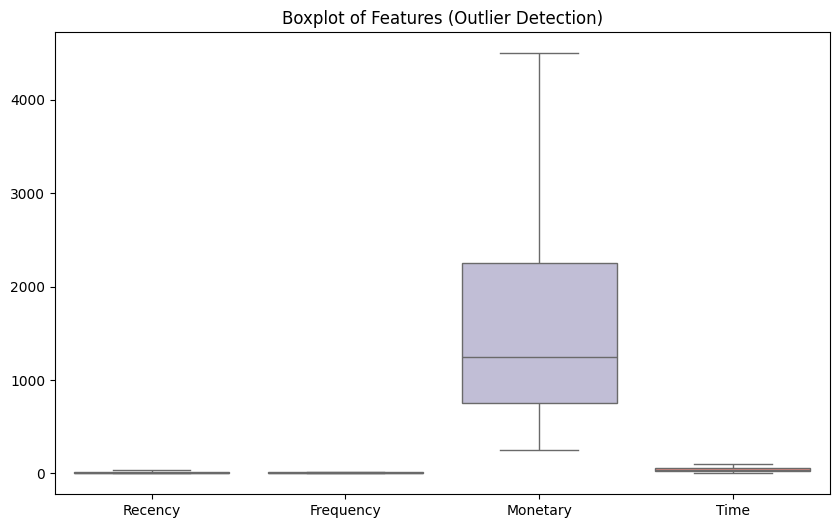

In [47]:
import matplotlib.pyplot as plt

metrics_df.plot(kind='bar', figsize=(10,6))
plt.title("Comparison of Models on Key Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


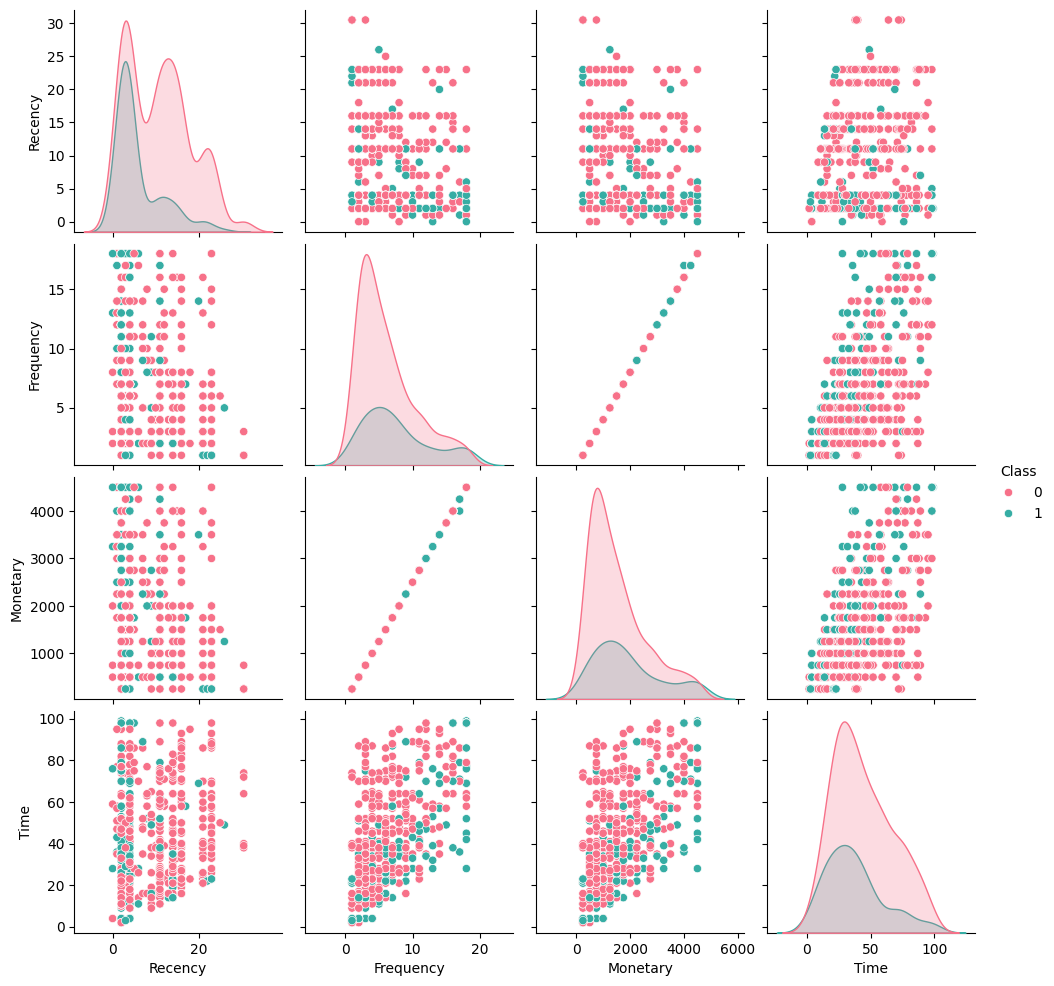

In [52]:
sns.pairplot(df[['Recency','Frequency','Monetary','Time','Class']], hue="Class", palette="husl")
plt.show()


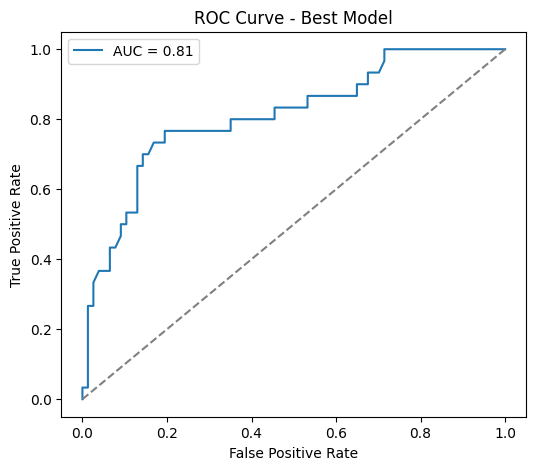

In [54]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve - Best Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [ ]:
lr = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42)
lr.fit(X_train_poly, y_train_res)


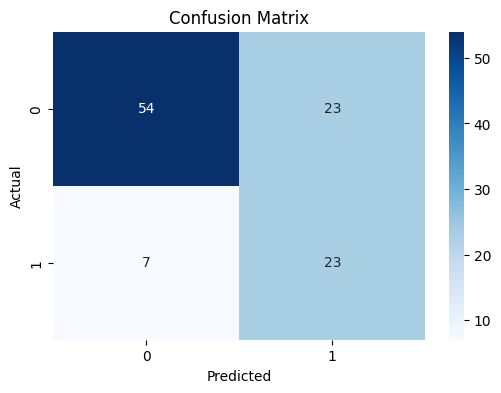

In [74]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [76]:
param_grid = {'C':[0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(
    LogisticRegression(class_weight='balanced', solver='liblinear'),
    param_grid, scoring='f1', cv=5
)
grid.fit(X_train_poly, y_train_res)

best_model = grid.best_estimator_

# Evaluate best model
y_pred_best = best_model.predict(X_test_poly)
y_prob_best = best_model.predict_proba(X_test_poly)[:,1]

print("Best Model Classification Report:\n", classification_report(y_test, y_pred_best))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_best))


Best Model Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.70      0.78        77
           1       0.50      0.77      0.61        30

    accuracy                           0.72       107
   macro avg       0.69      0.73      0.69       107
weighted avg       0.78      0.72      0.73       107

ROC-AUC Score: 0.8103896103896104


In [78]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics for the best Logistic Regression
accuracy = accuracy_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
roc_auc = roc_auc_score(y_test, y_prob_best)

metrics = {"Accuracy": accuracy, "F1-Score": f1, "ROC-AUC": roc_auc}


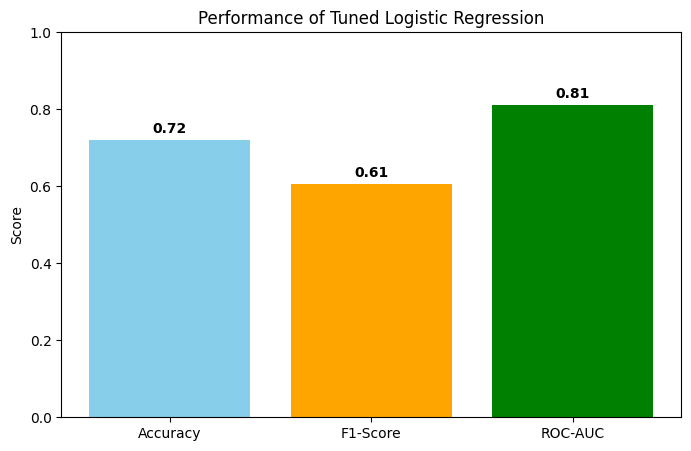

In [82]:
plt.figure(figsize=(8,5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue','orange','green'])
plt.ylim(0,1)
plt.title("Performance of Tuned Logistic Regression")
plt.ylabel("Score")

for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()


In [64]:
import os
os.getcwd()


'C:\\Users\\amana\\u_m_files'

In [66]:
import pickle

# Save Logistic Regression model
with open("lr_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save Scaler
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Files saved successfully!")


Files saved successfully!


In [68]:
import pickle

model = pickle.load(open("lr_model.pkl", "rb"))
scaler = pickle.load(open("scaler.pkl", "rb"))

print("Model expects features:", model.n_features_in_)
print("Scaler expects features:", scaler.n_features_in_)


Model expects features: 10
Scaler expects features: 4
